# Atuação em simulações de trânsito baseado na detecção de anomalias em trechos de vias

Apresentaremos nossas análises a respeito do experimento de "Atuação em simulações de trânsito baseado na detecção de anomalias em trechos de vias". Inicialmente realizamos uma validação dos modelos com um escopo reduzido e em seguida executamos simulações e análises com cenários de maior magnitude.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(color_codes=True)
import numpy as np
from matplotlib import rc
COLUMNS = ["hour", "minute", "last_tick", "type", "trip_id", "last_link", "duration", "distance"]

### Campos dos conjuntos de dados

Durante o relatório faremos análise a partir dos conjuntos de dados de **trechos percorridos por veículos** durante as simulações. Esses arquivos estão em formato `csv` e contém os seguintes campos:

- **hour**: Em que hora começamos a executar aquela simulação                                                                                      
                                                                                                                                          
- **minute**: Em que minuto começamos a executar aquela simulação                                                                              
                                                                                                                                          
- **last_tick**: O último tick de simulação daquela viagem                                                                                                                           
                                                                                                                                          
- **type**: O tipo do dado no arquivo `.csv` (todas serão do tipo **arrival**)                                                                                                                            
                                                                                                                                          
- **trip_id**: O identificador daquela viagem                                                                                            
                                                                                                                                          
- **last_link**: A última aresta do grafo por onde aquela viagem passou (permite encontrar o destino final de uma viagem)                                                                                 
                                                                                                                                          
- **duration**: A duração total de uma viagem (ou seja, podemos inferir o início de uma viagem combinando a duração e o primeiro tick)                                                                                  
                                                                                                                                          
- **distance**: A distância total percorrida durante uma viagem

Os conjuntos de dados utilizados foram os seguintes:
- [Conjuntos de dados de validação](https://github.com/LSS-USP/pmv_experiment/tree/master/validation/datasets)
- [Conjuntos de dados de maior magnitude](https://github.com/LSS-USP/pmv_experiment/tree/master/city_scale/datasets)

# Validação do modelo de simulação

Inicialmente validamos o modelo de simulação de eventos de trânsito (e utilização de PMVs - Placas de Mensagem Variada) implementada no **InterSCSimulator**. Para isso utilizamos um contexto controlado, composto de um grafo simples e um número reduzido de viagens.

Executamos três cenários para a validação:

- Sem evento de fechamento de rua;

- Com um evento de fechamento de rua mas sem o auxílio de PMVs;

- Com um evento de fechamento de rua e auxílio de PMVs.

Executamos vinte (20) simulações de 10 minutos para cada cenário, resultando em três conjuntos de dados (um por cenário) que continham a saída de todas essas rodadas de simulação. Ao final realizamos análises encima desses conjuntos de dados.

## Entrada do Cenário de Validação

A seguir descreveremos as duas entradas da simulação: a descrição do mapa da cidade e a lista de viagens.

### Mapa da Cidade

Utilizamos o grafo abaixo como mapa da cidade nos três cenários, composto de  8 vértices e 16 arestas. O grafo é apresentado como não-direcionado, mas na verdade é um grafo direcionado onde todos os vértices apresentados têm ida e volta:

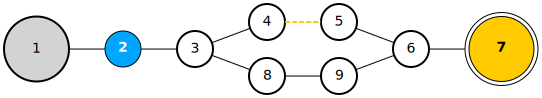

In [2]:
from graphviz import Graph

g = Graph('G')
g.attr(rankdir='LR', size='20', splines='true', ranksep='0.5')
g.attr('node', shape='circle', rankdir='LR', style='bold', fontname = "verdana")

g.node('1', style='filled,bold', fixedsize='true', width='.9')
g.node('2', fillcolor='#00A5FF', label='<<b>2</b>>', fontcolor='white', style='filled')  
g.node('3')
g.node('4')
g.node('5')
g.node('6')
g.node('7', shape='doublecircle', fillcolor='#FFCB00', label='<<b>7</b>>', fontcolor='black', style='filled', fixedsize='true', width='.9')
g.node('8')
g.node('9')
        
g.edge('1', '2')
g.edge('2', '3')
g.edge('3', '4')
g.edge('4', '5', style='dashed, bold', color='#FFCB00')
g.edge('5', '6')
g.edge('3', '8')
g.edge('8', '9')
g.edge('9', '6')
g.edge('6', '7')
g

O grafo acima modela a cidade da seguinte forma:

- Os vértices representam início/fim de uma ou mais ruas (no grafo acima, por exemplo, os vértices 1 e 7 não são o encontro de ruas pois estão nos cantos e só uma aresta sai deles, mas os outros sim

- As arestas representam as ruas de uma cidade

- As arestas têm o mesmo tamanho (comprimento 1)

- A cada tick (etapa de simulação) os veículos andam uma aresta

Adotamos a seguinte nomenclatura para separar vértices e arestas especiais:

- A aresta amarela representa a rua da cidade onde ocorrerá o evento de fechamento de rua (nenhum veículo passará por essa aresta durante um evento) - essa aresta só será afetada no cenário com evento

- O vértice cinza representa a origem de todas as viagens simuladas

- O vértice amarelo representa o destino das viagens.

- O vértice azul representa o local da cidade que contém uma PMV que alertará os motoristas sobre o fechamento de ruas

### Lista de Viagens

Nos três cenários utilizamos um total de 100 viagens, que tinham como origem o `vértice 1` e como destino o `vértice 7`.

## Análise dos Dados

### Hipóteses

Abaixo comparamos os valores de distância média dos três cenários. A nossa hipótese era que todos os veículos utilizassem o seguinte caminho no grafo apresentado anteriormente:

- No cenário **sem evento**, que o caminho fosse o apresentado abaixo. As arestas de cor roxa representam o caminho inicial calculado e o seguido pelos veículos (as arestas que não foram usadas foram ocultadas). Note que, quando no **vértice 3**, ele opta pelo **vértice 4**: o critério de desempate é qual vértice vem primeiro no arquivo de entrada, onde o montamos com os vértices de menor índice primeiro.

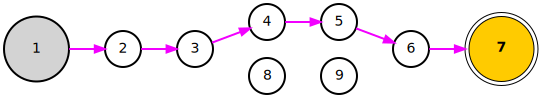

In [3]:
from graphviz import Digraph

g = Digraph('G')

g.attr(rankdir='LR', size='20', splines='true', ranksep='0.5')
g.attr('node', shape='circle', rankdir='LR', style='bold', fontname = "verdana")

g.node('1', style='filled,bold', fixedsize='true', width='.9')
g.node('3')
g.node('4')
g.node('5')
g.node('6')
g.node('7', shape='doublecircle', fillcolor='#FFCB00', label='<<b>7</b>>', fontcolor='black', style='filled', fixedsize='true', width='.9')
g.node('8')
g.node('9')

g.edge('1', '2', style='bold', color='#F200FF')
g.edge('2', '3', style='bold', color='#F200FF')
g.edge('3', '4', style='bold', color='#F200FF')
g.edge('4', '5', style='bold', color='#F200FF')
g.edge('5', '6', style='bold', color='#F200FF')
g.edge('3', '8', style='invis')
g.edge('8', '9', style='invis')
g.edge('9', '6', style='invis')
g.edge('6', '7', style='bold', color='#F200FF')

g

- No cenário **com evento e sem PMV** que fosse utilizado o percurso no mapa abaixo. As arestas de **cor roxa** representam o caminho inicial que chegou a ser percorrido pelos veículos; as arestas de **cor preta** o caminho inicial calculado mas que não foi percorrido devido ao evento de trânsito na aresta `4 -> 5`; e as arestas de **cor verde** o caminho recalculado e percorrido após se deparar com a aresta proibida. A aresta proibida (`4 -> 5`) está tracejada.

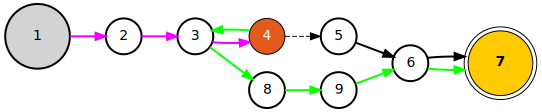

In [4]:
from graphviz import Digraph

g = Digraph('G')
g.attr(rankdir='LR', size='20', splines='true', ranksep='0.5')
g.attr('node', shape='circle', rankdir='LR', style='bold', fontname = "verdana")

g.node('1', style='filled,bold', fixedsize='true', width='.9')
g.node('3')
g.node('4', fillcolor='#E25A1C', fontcolor='white', style='filled')


g.node('5')
g.node('6')
g.node('7', shape='doublecircle', fillcolor='#FFCB00', label='<<b>7</b>>', fontcolor='black', style='filled', fixedsize='true', width='.9')
g.node('8')
g.node('9')

g.edge('1', '2', style='bold', color='#F200FF')
g.edge('2', '3', style='bold', color='#F200FF')

g.edge('4', '3', style='bold', color='#0DFF00')
g.edge('3', '4', style='bold', color='#F200FF')
g.edge('4', '5', style='dashed')
g.edge('5', '6', style='bold')
g.edge('3', '8', style='bold', color='#0DFF00')
g.edge('8', '9', style='bold', color='#0DFF00')
g.edge('9', '6', style='bold', color='#0DFF00')
g.edge('6', '7', style='bold', color='#0DFF00')
g.edge('6', '7', style='bold')

g

* No cenário **com evento e com auxílio de PMV** que fosse utilizado o grafo abaixo. Novamente ocorre um evento de fechamento de trânsito na aresta `4 -> 5`, tornando-a proibida, contudo uma PMV posicionada no vértice 2 (cor azul) notifica os motoristas a respeito do evento, fazendo com que a rota seja recalculada previamente. Utilizamos a mesma notação, onde as arestas de **cor roxa** representam o caminho inicial que chegou a ser percorrido pelos veículos; as arestas de **cor preta** o caminho inicial calculado mas que não foi percorrido devido a notificação da PMV posicionada no vértice `2`; as arestas de **cor verde** representam o caminho recalculado e percorrido (agora recalculados pela notificação do PMV). A aresta proibida (`4 -> 5`) continua tracejada. Ainda, esperávamos que certos veículos utilizassem o mesmo caminho caso não houvesse PMV (ignorando as notificações), tendo resultado igual ao cenário citado anteriormente; cerca de `1/3` dos veículos que são notificados utilizam o novo caminho recalculado, e `2/3` utilizam o caminho inicial.

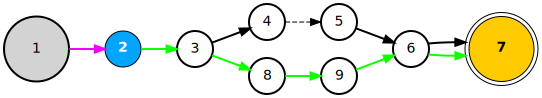

In [5]:
from graphviz import Digraph

g = Digraph('G')
g.attr(rankdir='LR', size='20', splines='true', ranksep='0.5')
g.attr('node', shape='circle', rankdir='LR', style='bold', fontname = "verdana")

g.node('1', style='filled,bold', fixedsize='true', width='.9')
g.node('2', fillcolor='#00A5FF', label='<<b>2</b>>', fontcolor='white', style='filled')  
g.node('3')
g.node('4')
g.node('5')
g.node('6')
g.node('7', shape='doublecircle', fillcolor='#FFCB00', label='<<b>7</b>>', fontcolor='black', style='filled', fixedsize='true', width='.9')
g.node('8')
g.node('9')

g.edge('1', '2', style='bold', color='#F200FF')
g.edge('2', '3', style='bold', color='#0DFF00')

g.edge('3', '4', style='bold')

g.edge('4', '5', style='dashed')
g.edge('5', '6', style='bold')
g.edge('3', '8', style='bold', color='#0DFF00')
g.edge('8', '9', style='bold', color='#0DFF00')
g.edge('9', '6', style='bold', color='#0DFF00')
g.edge('6', '7', style='bold', color='#0DFF00')
g.edge('6', '7', style='bold')

g

### Resultados e Conclusões

Inicialmente, carregamos os conjuntos de dados construídos a partir das simulações realizadas. Daqui em diante chamaremos o cenário que não ocorre o evento de `baseline`, o cenário onde ocorre o evento mas que não possui PMV de `events` e o cenário onde ocorre o evento e há o auxílio de PMV de `pmv`:

In [2]:
# carregando os dados
baseline_dataset_path = "validation/datasets/baseline_scenario/output.csv"
events_dataset_path = "validation/datasets/events_scenario/output.csv"
pmv_dataset_path = "validation/datasets/pmv_scenario/output.csv"

baseline_df = (pd
    .read_csv(baseline_dataset_path, delimiter=";", header=None, names=COLUMNS)
    .assign(first_tick=lambda x: x['last_tick'] - x['duration']))

events_df = (pd
    .read_csv(events_dataset_path, delimiter=";", header=None, names=COLUMNS)
    .assign(first_tick=lambda x: x['last_tick'] - x['duration']))

pmv_df = (pd
    .read_csv(pmv_dataset_path, delimiter=";", header=None, names=COLUMNS)
    .assign(first_tick=lambda x: x['last_tick'] - x['duration']))

Em seguida, agrupamos as viagens (através do ``groupby``) utilizando o campo `last_link` (esse campo indica qual foi a última rua daquela viagem). Todas as viagens têm a mesma origem e destino, sendo agrupadas. Após, calculamos a média dos valores de todos os campos de um grupo. Ao final, no campo `duration` (duração da viagem) será apresentado a média da duração das viagens, no campo `distance` (distância da viagem) a média das distâncias da viagem, e assim sucessivamente.

In [7]:
df1 = (baseline_df[['last_link', 'distance', 'duration']]
        .assign(scenario=r"Sem evento"))

df2 = (events_df[['last_link', 'distance', 'duration']]
        .assign(scenario=r"Com evento"))

df3 = (pmv_df[['last_link', 'distance', 'duration']]
        .assign(scenario=r"Com evento e PMV"))

Após, construímos um conjunto de dados final composto da média dos três cenários apresentados (através do `append`). Nos preocupamos somente com os campos `last_link`, `distance` e `duration` pois serão os únicos campos usados na análise apresentada a seguir.

In [8]:
df = df1.append(df2).append(df3)

Por fim, abaixo apresentamos os resultados finais dos três cenários utilizando gráficos de barras. Segundo nossas hipóteses (os três caminhos apresentados anteriormente), esperávamos que o cenário **sem evento** percorresse 6 arestas, o cenário **com evento e sem PMV** percorresse 8 arestas e o cenário **com evento e PMV** percorresse entre 6 e 8 arestas (esperávamos que alguns veículos ignorassem as notificações). Nossas hipóteses foram confirmadas, conforme o gráfico abaixo.

No handles with labels found to put in legend.


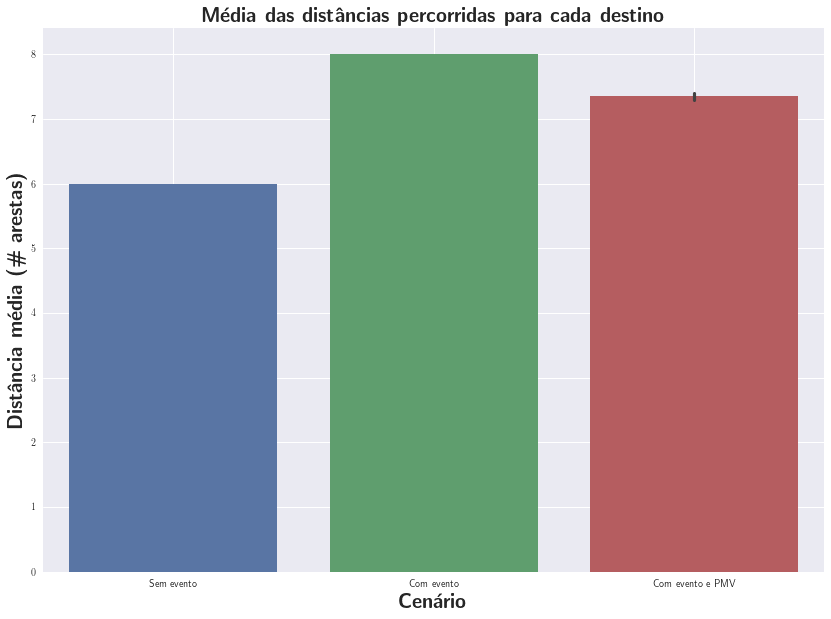

In [9]:
rc('text', usetex=True)
plt.figure(figsize=(14,10))

ax = sns.barplot(data=df, x='scenario', y='distance')

ax.set_xlabel(r'\textbf{Cen\'ario}', fontsize='20')
ax.set_ylabel(r'\textbf{Dist\^ancia m\'edia (\# arestas)}', fontsize='20')

plt.legend(loc="best",prop={"size":15})
plt.title(r"\textbf{M\'edia das dist\^ancias percorridas para cada destino}", size=20)
plt.grid(True)
sns.set(font_scale = 1.5)

plt.show()

Fizemos uma análise semelhante também para as durações das viagens, conforme apresentado no gráfico abaixo.

Uma viagem dura sempre 2 ticks mais o tempo utilizado para percorrer as arestas (uma aresta por tick) e o recálculo de um caminho custa um tick. Por isso, esperávamos agora que o cenário **sem evento** durasse 8 ticks (2+6 por terem 6 arestas), o cenário **com evento e sem PMV** durasse 11 ticks (2+8 arestas+1 pelo recálculo) e o cenário **com evento e PMV** durasse entre 9 e 11 ticks (2+8 arestas+1 pelo recálculo para os motoristas que ignorem o PMV e 2+6 arestas+1 para os motoristas que sigam a notificação do PMV). Nossas hipóteses foram confirmadas, conforme o gráfico abaixo.

No handles with labels found to put in legend.


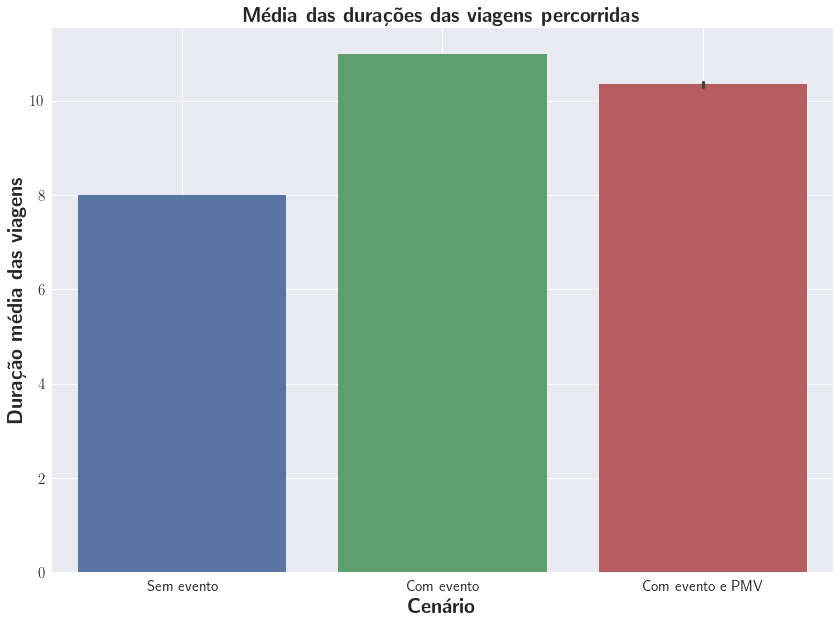

In [10]:
plt.figure(figsize=(14,10))

ax = sns.barplot(data=df, x='scenario', y='duration')

ax.set_xlabel(r'\textbf{Cen\'ario}', fontsize='20')
ax.set_ylabel(r'\textbf{Dura\c{c}\~ao m\'edia das viagens}', fontsize='20')

plt.legend(loc="best",prop={"size":15})
plt.title(r"\textbf{M\'edia das dura\c{c}\~oes das viagens percorridas}", size=20)
plt.grid(True)
sns.set(font_scale = 1.5)

plt.show()

Dessa forma, entendemos que tanto o modelo de trânsito quanto o modelo de PMVs implementados no InterSCSimulator são condizentes com o que esperávamos e que podiamos, de fato, utilizarmos num cenário maior.

# Simulação de maior escala

A seguir apresentaremos nossa análise para uma simulação com uma escala maior, que se assemelhe a cidade de São Paulo. Neste experimento utilizaremos um mapa real da cidade de São Paulo e como referência viagens da pesquisa Origem-Destino do ano de 2007. No cenários de fechamento de rua, um acidente ocorre na Avenida Rebouças e as PMVs são posicionadas próximas a área do acidente.

Nesta simulação executamos cinco cenários:

- Sem o evento de fechamento de rua;

- Com o evento de fechamento de rua mas sem o auxílio de PMVs;

- Com o evento de fechamento de rua e auxílio de 2 PMVs;

- Com o evento de fechamento de rua e auxílio de 4 PMVs;

- Com o evento de fechamento de rua e auxílio de 6 PMVs.

Executamos a simulação dos cenários vinte (20) vezes e construímos cinco conjuntos de dados (um por cenário) que continham a saída de todas essas rodadas de simulação. Ao final realizamos análises encima desses conjuntos de dados.

## Entrada da Simulação

A seguir descreveremos as duas entradas da simulação do cenário realístico: a descrição do mapa da cidade e a lista de viagens.

### Mapa da Cidade

Utilizamos o mapa da cidade de São Paulo como grafo a ser utilizado na simulação. O mapa é um arquivo `xml` construído à partir do mapa real da cidade disponível no Open Street Map.

### Lista de Viagens

Utilizamos todas as viagens da pesquisa Origem Destino do ano de 2007, mas reduzimos o número dessas viagens para 1/5 da frequência. Então, todas as viagens continuam ocorrendo, mas uma viagem que ocorre 1000 passa a ocorrer 200 vezes.
No total, tivemos mais de **65000** viagens por round.

### Paineis de Mensagem Variada (PMVs)

Abaixo apresentamos os locais onde posicionamos as PMVs dos cenários simulados. As duas placas **de cor azul** foram utilizadas no cenário com 2 PMVs, as placas de **cor azul e verde** foram utilizadas no cenário com 4 PMVs e todas as placas (cores **azul, verde e vermelho**) foram utilizadas no cenário com 6 PMVs.

![Mapa com PMVs](img/map.png)


## Análise dos Dados

Inicialmente, carregaremos os cinco conjuntos de dados (datasets).

### Hipótese

Abaixo comparamos os valores de distância média dos cinco cenários. A nossa hipótese era que o cenário sem o evento fosse o limite inferior e o cenário com o evento (e sem PMVs) o limite superior. Ou seja: o cenário sem o evento deveria ser o que os motoristas **demorassem menos** em seus trajetos, percorrendo **distâncias menores**, e o com o evento que **demorassem mais**, percorrendo **distâncias maiores**.

Entre esses dois limiares esperávamos que ficassem os cenários com PMVs, onde com 2 e 4 PMVs uma diferença relevante com relação a não ter PMVs ocorresse, e 6 PMVs não impactasse tanto (possibilitando concluir que a adição das últimas duas placas não tivesse tanto proveito).

### Resultados e Conclusões

Inicialmente, carregaremos os cinco datasets gerados. Os datasets são os seguintes:

- Dataset 1: O chamaremos de `non_events`, e apresenta uma simulação no cenário onde não ocorrem acidentes

- Dataset 2: O chamaremos de `events`, e apresenta uma simulação no cenário onde ocorrem acidentes e não existem PMVs disponíveis

- Dataset 3: O chamaremos de `events_pmv2`, e apresenta uma simulação no cenário onde ocorrem acidentes e existem dois PMVs

- Dataset 4: O chamaremos de `events_pmv4`, e apresenta uma simulação no cenário onde ocorrem acidentes e existem quatro PMVs

- Dataset 5: O chamaremos de `events_pmv6`, e apresenta uma simulação no cenário onde ocorrem acidentes e existem seis PMVs

In [3]:
NON_EVENTS_DATASET_PATH = "city_scale/datasets/baseline_scenario/output.csv"
EVENTS_DATASET_PATH = "city_scale/datasets/events_scenario/output.csv"
EVENTS_2PMVS_DATASET_PATH = "city_scale/datasets/pmv_2_scenario/output.csv"
EVENTS_4PMVS_DATASET_PATH = "city_scale/datasets/pmv_4_scenario/output.csv"
EVENTS_6PMVS_DATASET_PATH = "city_scale/datasets/pmv_6_scenario/output.csv"


non_events_df = (pd
    .read_csv(NON_EVENTS_DATASET_PATH, delimiter=";", header=None, names=COLUMNS)
    .assign(has_events=False)
    .assign(pmvs=0))

events_df = (pd
    .read_csv(EVENTS_DATASET_PATH, delimiter=";", header=None, names=COLUMNS)
    .assign(has_events=True)
    .assign(pmvs=0))

events_2pmvs_df = (pd
    .read_csv(EVENTS_2PMVS_DATASET_PATH, delimiter=";", header=None, names=COLUMNS)
    .assign(has_events=True)
    .assign(pmvs=2))

events_4pmvs_df = (pd
    .read_csv(EVENTS_4PMVS_DATASET_PATH, delimiter=";", header=None, names=COLUMNS)
    .assign(has_events=True)
    .assign(pmvs=4))

events_6pmvs_df = (pd
    .read_csv(EVENTS_6PMVS_DATASET_PATH, delimiter=";", header=None, names=COLUMNS)
    .assign(has_events=True)
    .assign(pmvs=6))

datasets = [non_events_df, events_df, events_2pmvs_df, events_4pmvs_df, events_6pmvs_df]

Então, utilizamos somente as viagens que sofrem alguma alteração em suas durações (utilizamos o método `nunique` e reitramos os que apresentam apenas uma ocorrência, que indica que a duração nunca muda). Preenchemos um arranjo chamado `affected_trips` com a lista de viagens que tem durações variando em algum conjunto de dados.

In [7]:
def count_durations_ocorrences(data):
    return data.assign(ocrr=data.duration.nunique())[['ocrr', 'trip_id']].iloc[0]

affected_trips = []

for dataset in datasets:
    df = (dataset
     .groupby('trip_id')
     .apply(count_durations_ocorrences))
    
    dataset_affected_trips = df[df.ocrr != 1].trip_id.values
    
    for trip in dataset_affected_trips:
        affected_trips.append(trip)
print("non_affected =>", len(affected_trips))
affected_trips = np.unique(affected_trips)
print("len affected trips =>", len(affected_trips))

non_affected => 8069
len affected trips => 2109


In [6]:
len(affected_trips)

2109

In [13]:
v1 = non_events_df[non_events_df.trip_id.isin(affected_trips)].assign(scenario="Sem Evento")
v2 = events_df[events_df.trip_id.isin(affected_trips)].assign(scenario="Com Evento")
v3 = events_2pmvs_df[events_2pmvs_df.trip_id.isin(affected_trips)].assign(scenario="Com Evento e 2 PMVs")
v4 = events_4pmvs_df[events_4pmvs_df.trip_id.isin(affected_trips)].assign(scenario="Com Evento e 4 PMVs")
v5 = events_6pmvs_df[events_6pmvs_df.trip_id.isin(affected_trips)].assign(scenario="Com Evento e 6 PMVs")

# Troco os underscores (_) por pontos (.) pois utilizarei o LaTeX como engine gráfica
v1 = (v1.assign(trip_id=lambda x: x.trip_id.str.replace("_", ".")))

v2 = (v2.assign(trip_id=lambda x: x.trip_id.str.replace("_", ".")))

v3 = (v3.assign(trip_id=lambda x: x.trip_id.str.replace("_", ".")))

v4 = (v4.assign(trip_id=lambda x: x.trip_id.str.replace("_", ".")))

v5 = (v5.assign(trip_id=lambda x: x.trip_id.str.replace("_", ".")))

Em seguida, criamos um novo dataset com apenas as viagens afetadas (arranjo `affected_trips`) e o armazenamos no dataframe `affected_trips_df`. Só utilizaremos no passo a seguir os atributos `pmvs` e `duration`. 

In [14]:
affected_trips_df = v1.append(v2).append(v3).append(v4).append(v5)

final_df = affected_trips_df[['scenario', 'duration']]

Abaixo apresentamos as médias e desvios padrão de tempo de viagem entre os cinco conjuntos de dados. Os dados são relativamente próximos, o que não permite conclusões (a visualização não fica clara).

No handles with labels found to put in legend.


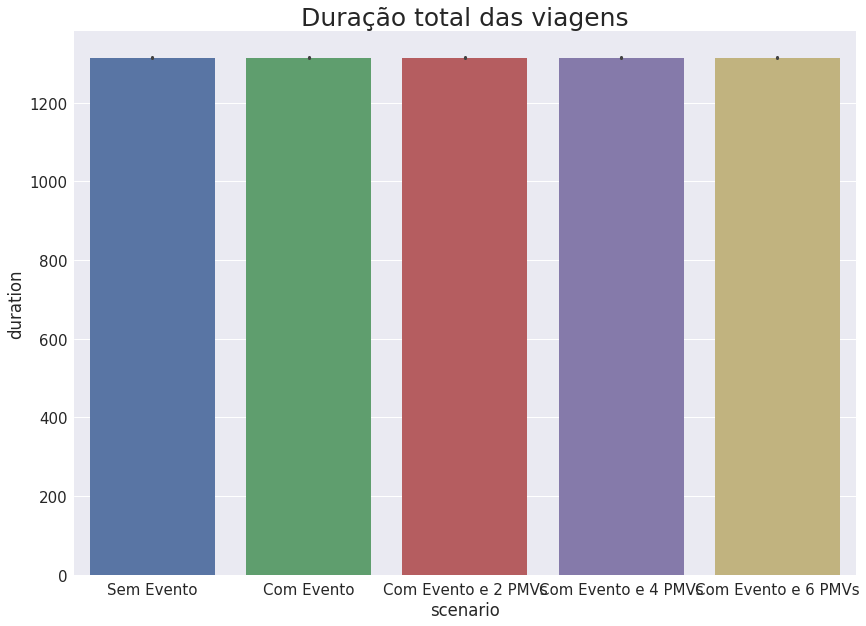

In [15]:
rc('text', usetex=False)

plt.figure(figsize=(14,10))

ax = sns.barplot(data=final_df, x='scenario', y='duration')
plt.legend(loc="best",prop={"size":20})
plt.title("Duração total das viagens", size=25)
sns.set(font_scale = 1.5)

plt.show()

Para facilitar a visualização dos dados anteriores, faremos a porcentagem da piora entre o cenário sem evento e os cenários com o evento (incluindo PMVs), pois sabemos que o cenário **sem evento** pode ser considerado mais rápido que os outros - dessa forma, o utilizaremos como **limite inferior**.

Calculamos as médias dos diferentes cenários:

In [16]:
lower_bound = v1.duration.mean()
lower_bound

1313.7326247602216

In [17]:
v2_df = v2.duration.mean()
v3_df = v3.duration.mean()
v4_df = v4.duration.mean()
v5_df = v5.duration.mean()

Então, calculamos a porcentagem com relação aos outros cenários; armazenamos em:

- `p1` a diferença de porcentagem entre o cenário **com o evento** e **sem o evento**

- `p2` a diferença de porcentagem entre o cenário **com o evento e 2 PMVs** e **sem o evento**

- `p3` a diferença de porcentagem entre o cenário **com o evento e 4 PMVs** e **sem o evento**

- `p4` a diferença de porcentagem entre o cenário **com o evento e 6 PMVs** e **sem o evento**

In [18]:
p1 = ((v2_df/lower_bound) -1)*100
p2 = ((v3_df/lower_bound) -1)*100
p3 = ((v4_df/lower_bound) -1)*100
p4 = ((v5_df/lower_bound) -1)*100

Por fim, montamos um `DataFrame` resultante com as diferenças percentuais.

In [19]:
raw_data = {
    '%': [p1, p2, p3, p4],
    'scenario': ['Com Evento', 'Com 2 PMVs', 'Com 4 PMVs', 'Com 6 PMVs']
}

df = pd.DataFrame(raw_data, columns = ['%', 'scenario'])

E apresentamos com um gráfico de barras a seguir.

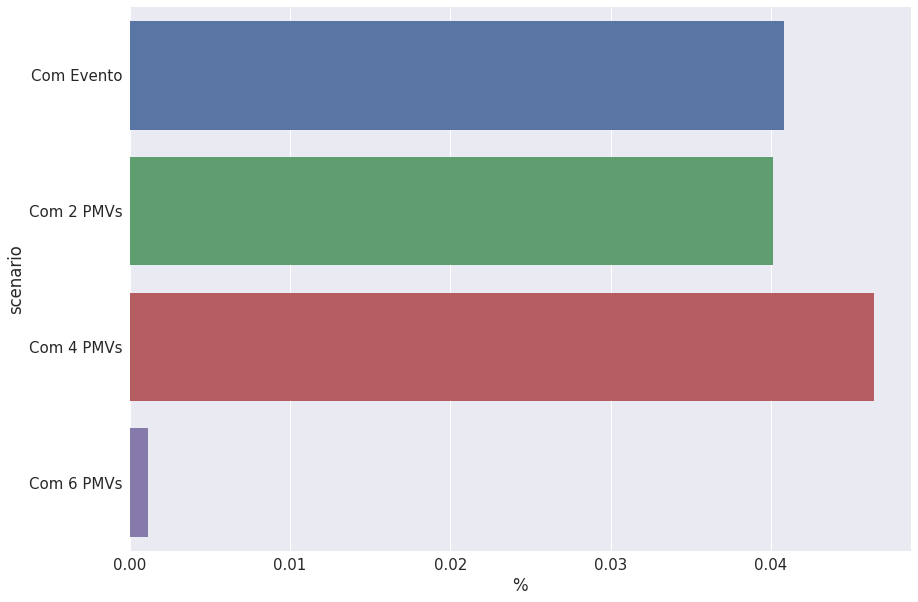

In [20]:
plt.figure(figsize=(14,10))

sns.barplot(data=df, x='%', y='scenario')

A partir dos resultados, observamos os seguintes fatos:

- A diferença entre os diferentes resultados não foi relevante (um dos gráficos, por exemplo, não possibilitou diferenciar os tempos de duração entre os diferentes cenários) - acreditamos que faça sentido pois os acidentes são sempre em um único ponto bem específico da cidade, mas as viagens ocorrem por toda a cidade, não sendo afetadas

- O fato de todos os valores serem positivos indica que o cenário sem o evento é, de fato, o limite inferior

- O cenário **com o evento e sem PMVs** apresentou duração menor que com **o evento e 4 PMVs**, não podendo ser um limite superior, o que nega uma de nossas hipóteses

- O cenário **com o evento e 4 PMVs** foi o que teve a maior duração em média, o que não esperávamos. Atribuímos esse resultado ao mal posicionamento das placas nesse cenário (placas verdes e azuis). Pelo fato das placas estarem muito próximas, tivemos em grande parte viagens que tiveram seu caminho **recalculado várias vezes** (cada placa alerta veículos sempre que uma rua em seu percurso está mais lenta que o normal), e o constante recálculo de trajeto aumenta a duração total. O novo caminho recalculado pode continuar tendo PMVs, o que acarreta em um novo recálculo de caminho.

- O cenário **com o evento e 6 PMVs** teve boa melhora em relação aos outros cenários, o que nega outra hipótese nossa. Isso ocorreu porque o posicionamento das placas **de cor vermelha** favorece a notificação, por estar localizada em um extremo da via de acidentes, evitando a aproximação do caminho do veículo e outros PMVs, diminuindo a quantidade de vezes que o caminho é recalculado.

Identificamos as seguintes limitações neste experimento:

- Devido a utilização de um único evento de fechamento de rua e em um lugar específico, a visualização do impacto de uso de PMVs foi prejudicada

- Devido ao posicionamento não-ótimo de algumas placas, o resultado final não foi ideal (mas nos ajudou a concluir que o posicionamento das placas têm grande influência)

- Fatores externos (como qualidade da rede, recursos computacionais disponíveis, dentre outros) afetaram os resultados

- Analisamos as viagens que ocorrem durante toda a cidade de São Paulo, mas o evento é em um ponto específico da cidade. Seria melhor se tivéssemos como filtrar as viagens que não são da região, de modo que usássemos somente viagens próximas ao evento

Com as discussões apresentadas, concluímos que:

- A localização dos PMVs está fortemente correlacionado com o quanto a duração da viagem vai ser melhorada ou não. Placas muito próximas podem ter efeito contrário

- De maneira geral, entendemos que a utilização de PMVs não afeta substancialmente o trânsito da cidade. Contudo, em casos onde os eventos que causam fechamento de rua ocorrem frequentemente em uma mesma região e as placas sejam muito bem localizadas ao seu redor.